- Exercici 1
Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) 
de DelayedFlights.csv. Considera si el vol ha arribat tard o no (ArrDelay > 0).

-DECISION TREE (no gaire bo pq hauria d'agrupar delays en classes)



- Exercici 2
Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confiança i d’altres mètriques 
més avançades.

- Exercici 3
Entrena’ls utilitzant els diferents paràmetres que admeten.

- Exercici 4
Compara el seu rendiment utilitzant l’aproximació traint/test o cross-validation.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import datetime as dt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import pydotplus
import graphviz

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import mean_squared_error

# Load libraries
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image

### Carregar bloc de dades

In [19]:
flightsdf=pd.read_csv('DelayedFlights.csv', index_col=0) #a vegades cal posar index_col=0 si no fos detectat inicialment

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Netejo Bloc de dades

In [20]:
#elimino els que NO han volat (airtime=0 o cancellats)
flightsdf.drop(flightsdf[flightsdf.AirTime==0].index, inplace=True) #, axis=0, inplace=True)
flightsdf.drop(flightsdf[flightsdf.Cancelled!=0].index, inplace=True)


flightsdf['DepDate'] = flightsdf['Month']*100+flightsdf['DayofMonth'] ###a enter, sense ,format='%Y%m%d' FORA flightsdf['Year']*10000
    ## després la posaré en BINS per mesos, quinzenal o setmanal, segons com vagi de memoria

flightsdf.drop(['Year', 'Month', 'DayofMonth', 'Cancelled','CancellationCode', 'TailNum', 'Diverted', 'UniqueCarrier', 'FlightNum'], axis=1, inplace=True)
flightsdf.dropna(inplace=True) #puc eliminar els NaN en general o podria eliminar només els que no tenen retards
#flightsdf.fillna(0) # o elimino els nan passant-los a 0

##com que UniqueCarrier concatenat amb FlightNum tenen assignades una hora de sortida determinada s'eliminen també

### Exploro abans de seguir amb la neteja

Text(0, 0.5, 'Frequency')

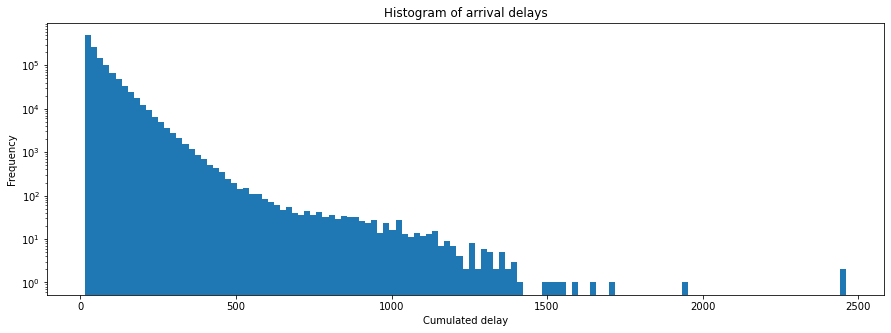

In [21]:
plt.figure(figsize=(15, 5))   ###semla que es podrien posar en bins de 50 minuts o 1h aprox
plt.hist(flightsdf['ArrDelay'], bins=125) ## veiem que no hi ha delays de més de 1500 minuts normalment
plt.yscale('log')
plt.title('Histogram of arrival delays')
plt.xlabel('Cumulated delay')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

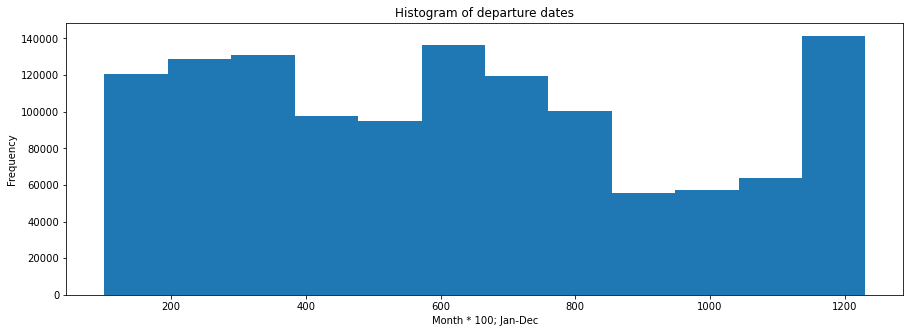

In [22]:
plt.figure(figsize=(15, 5))
plt.hist(flightsdf['DepDate'], bins=12) ## veiem que ho tinc per mesos, no és continua la variable generada !!!!
plt.yscale('linear')
plt.title('Histogram of departure dates')
plt.xlabel('Month * 100; Jan-Dec')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

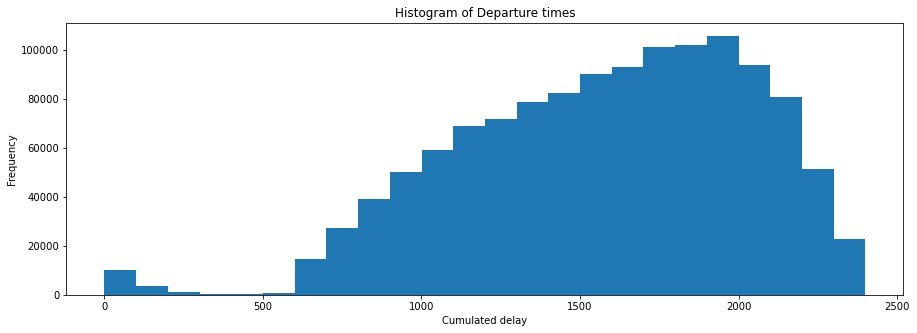

In [23]:
plt.figure(figsize=(15, 5))
plt.hist(flightsdf['DepTime'], bins=24) ## veiem que no hi ha delays de més de 1500 minuts normalment
plt.yscale('linear')
plt.title('Histogram of Departure times')
plt.xlabel('Cumulated delay')
plt.ylabel('Frequency')

### Acondiciono transformant variables

In [24]:
flightsdf['Delayed']=(flightsdf['ArrDelay']>15)*1  ### valor =15 perquè sino no hi ha informació dels delays parcials
#un OneHotEncoder també hauria funcionat???? ***********************

flightsdf['Delayed'].unique(), comprovo si de cas els valors son 0 o 1 

In [25]:
# FUNCIO per trobar gaps al format del DF (fora nan's, mida i forma)
def quick_analysis(df):
 print('General Information:')
 flightsdf.info()
 print('Rows and Columns:')
 print(df.shape)
 print('Column Names:')
 print(df.columns)
 print('Null Values:')
 print(df.apply(lambda x: sum(x.isnull()) / len(df)))
quick_analysis(flightsdf)

General Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247483 entries, 4 to 7009718
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   DayOfWeek          1247483 non-null  int64  
 1   DepTime            1247483 non-null  float64
 2   CRSDepTime         1247483 non-null  int64  
 3   ArrTime            1247483 non-null  float64
 4   CRSArrTime         1247483 non-null  int64  
 5   ActualElapsedTime  1247483 non-null  float64
 6   CRSElapsedTime     1247483 non-null  float64
 7   AirTime            1247483 non-null  float64
 8   ArrDelay           1247483 non-null  float64
 9   DepDelay           1247483 non-null  float64
 10  Origin             1247483 non-null  object 
 11  Dest               1247483 non-null  object 
 12  Distance           1247483 non-null  int64  
 13  TaxiIn             1247483 non-null  float64
 14  TaxiOut            1247483 non-null  float64
 15  CarrierDela

In [9]:
pd.value_counts(flightsdf['Origin']) # es podria agafar només el TOP 20%, pel criteri de Pareto

ORD    90611
ATL    87741
DFW    62073
DEN    46477
EWR    36115
       ...  
BJI        3
PUB        2
BLI        2
INL        1
PIR        1
Name: Origin, Length: 302, dtype: int64

In [10]:
pd.value_counts(flightsdf['Dest'])  # es podria agafar només el TOP 20%, pel criteri de Pareto

ORD    79624
ATL    71607
DFW    45964
EWR    40873
DEN    38613
       ...  
ITH       13
INL        9
BLI        7
BJI        4
PIR        1
Name: Dest, Length: 301, dtype: int64

array([[<AxesSubplot:title={'center':'DayOfWeek'}>,
        <AxesSubplot:title={'center':'DepTime'}>,
        <AxesSubplot:title={'center':'CRSDepTime'}>,
        <AxesSubplot:title={'center':'ArrTime'}>],
       [<AxesSubplot:title={'center':'CRSArrTime'}>,
        <AxesSubplot:title={'center':'ActualElapsedTime'}>,
        <AxesSubplot:title={'center':'CRSElapsedTime'}>,
        <AxesSubplot:title={'center':'AirTime'}>],
       [<AxesSubplot:title={'center':'ArrDelay'}>,
        <AxesSubplot:title={'center':'DepDelay'}>,
        <AxesSubplot:title={'center':'Distance'}>,
        <AxesSubplot:title={'center':'TaxiIn'}>],
       [<AxesSubplot:title={'center':'TaxiOut'}>,
        <AxesSubplot:title={'center':'CarrierDelay'}>,
        <AxesSubplot:title={'center':'WeatherDelay'}>,
        <AxesSubplot:title={'center':'NASDelay'}>],
       [<AxesSubplot:title={'center':'SecurityDelay'}>,
        <AxesSubplot:title={'center':'LateAircraftDelay'}>,
        <AxesSubplot:title={'center':'DepD

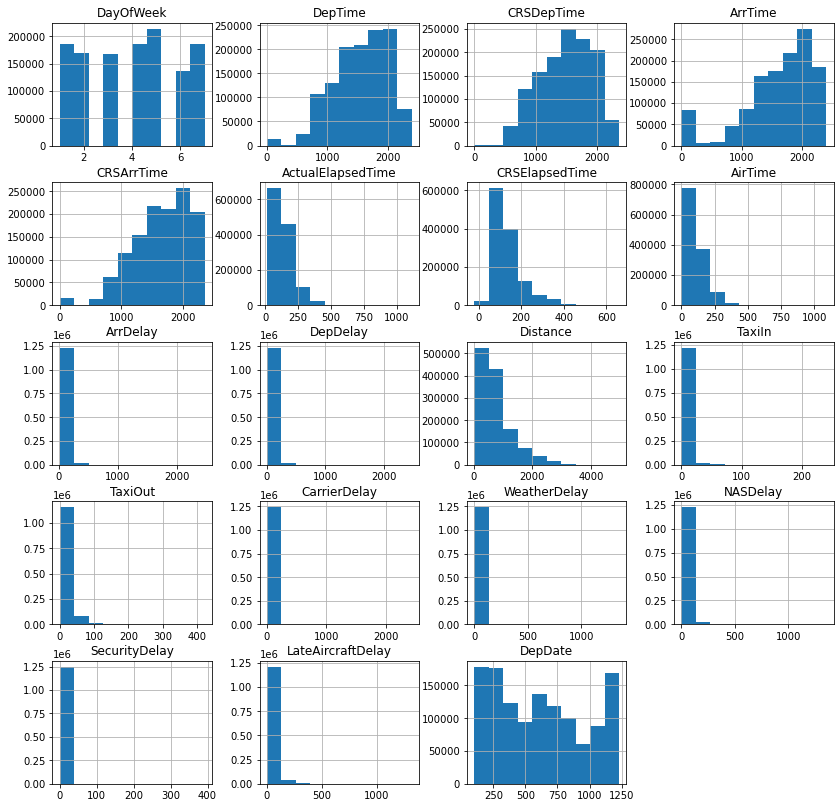

In [11]:
flightsdf[flightsdf.dtypes[(flightsdf.dtypes=="float64")|(flightsdf.dtypes=="int64")]
                        .index.values].hist(figsize=[14,14]) # ho tornaré a fer després de normalitzar???

dummy_cols = ['DayOfWeek'] #  'Origin''Dest' semblen les millors candidates, per dia de la setmana (finde) ciutat origen i destí
flightsdf = pd.get_dummies(flightsdf, columns = dummy_cols) #### genera dummy cols (1 col per feature de 1's o 0's)

### consumeixen mooolta més memòria de la que tinc a la màquina. Podria eliminar "dest" i "origin", que és, segons com, redundant amb "distance" i son 300 cols menys a cada una. FALTA MAQUINA

In [12]:
dummy_cols = ['DayOfWeek']
flightsdf = pd.get_dummies(flightsdf, columns = dummy_cols) 

flightsdf.drop(['Dest', 'Origin'], axis=1, inplace=True)

In [13]:
# binning i bucking, buckets a 0 250 600 1200 1800 5000 per a ArrDelay (target classificador)
# a DepTime per hores, cal fer entre 24 i 48 capses, amb la resta de hores
# a DepDate per mesos, cal fer 12 capses

bindept = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300, 2400]
group_namesdt = ['00','01', '02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
flightsdf['deptime'] = pd.cut(flightsdf['DepTime'], bindept, labels=group_namesdt)
pd.value_counts(flightsdf['deptime'])

19    105564
18    101957
17    101042
20     93650
16     92920
15     89987
14     82360
21     80838
13     78764
12     71517
11     68659
10     59245
22     51186
09     50116
08     38875
07     27088
23     22942
06     14646
00     10034
01      3674
02      1030
05       890
03       347
04       152
Name: deptime, dtype: int64

In [14]:
bindepd = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300]
group_namesdd = ['01','02','03','04','05','06','07','08','09','10','11','12']
                                    # es podria fer en blocs quinzenals, però tampoc es guanyaria res
flightsdf['depdate'] = pd.cut(flightsdf['DepDate'], bindepd, labels=group_namesdd)
pd.value_counts(flightsdf['depdate'])

# binning NUMPY ************per si vull fer ho en NUMPY directe
#X = np.array([[ -3., 5., 15 ],
#              [  0., 6., 14 ],
#              [  6., 3., 11 ]])
#est = preprocessing.KBinsDiscretizer(n_bins=[3, 2, 2], encode='ordinal').fit(X)
#est.transform(X)   

12    141373
06    136515
03    130998
02    128742
01    120784
07    119404
08    100602
04     97624
05     94772
11     63785
10     57079
09     55805
Name: depdate, dtype: int64

In [15]:
            ## ELIMINO columnes que ja he posat en bins, es podrien OneHotEncoder
flightsdf.drop(['DepDate','DepTime'], axis=1, inplace=True) #[,'ArrDelay']

In [16]:
#i finalment normalitzo les variables, TOTES, per facilitar la feina al fit()
#### CAL FER UN SCALING per tal de digerir l'algoritme de ML 

cols_to_norm = ['CRSDepTime', 'ArrTime', 'CRSArrTime',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime',
       'DepDelay',  'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay','ArrDelay'] # off side: 'DepDate','DepTime' pq no son continues,-deixo les CRS per embogir el model.
                            #'DayOfWeek','Origin', 'Dest' son strings que passen a sparse matrix, 'depdate','deptime','DayOfWeek' son BINS
                             #'ArrDelay' es el Target, com Delayed
n_test = flightsdf[cols_to_norm]

In [18]:
x = n_test.values   #preparo per només passar array()
x_scaled = preprocessing.MinMaxScaler().fit_transform(x)
left = pd.DataFrame(x_scaled, columns=cols_to_norm) # VARS normalizades, reconstrueixo df amb indexs
right= flightsdf.drop(cols_to_norm, axis=1) #['cols'] recalculades, what is left. fora- inplace=True

flightsdf = pd.merge(left, right, left_index=True, right_index=True)
flightsdf.columns

Index(['CRSDepTime', 'ArrTime', 'CRSArrTime', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'DepDelay', 'Distance', 'TaxiIn',
       'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'ArrDelay', 'Delayed', 'DayOfWeek_1',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'DayOfWeek_7', 'deptime', 'depdate'],
      dtype='object')

In [ ]:
quick_analysis(flightsdf)

#per DEFINICIO: Actual Elapsed Time=Taxi In+Taxi Out+Airtime operations ; 
#per DEFINICIO ArrivalDelay= carrierdelay+weatherdelay+NASdelay+LateAircraftdelay

#flightsdf['delaytime']=flightsdf['CarrierDelay']+flightsdf['WeatherDelay']+flightsdf['NASDelay']+flightsdf['SecurityDelay']+flightsdf['LateAircraftDelay']+flightsdf['TaxiIn']+flightsdf['TaxiOut'] #sense DEPDELAY


In [19]:
y = np.array(flightsdf.Delayed).astype(np.int64) # Target variable

flightsdf.drop(['Delayed'], axis=1, inplace=True) # elimino la columna target per passar el df complet

ArrivalDelay=flightsdf['ArrDelay'] #deso la columna target en continu per a models continus
flightsdf.drop(['ArrDelay'], axis=1, inplace=True)  # elimino la variable fàcil (que podria ser target si posada en bins)

X = np.array(flightsdf) #.reshape((-1, 1)) # Features


### X, y ### es podria transformar les hores en data unica i fora al TimeStamp, no sé si serviria de gaire

In [20]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0) 

# metode 1 classificador amb arbre de decisions (basic, binari)

In [21]:
# Create Decision Tree classifier object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifier
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [22]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.939958358701453


In [23]:
print("Confusion matrix: \n" ,metrics.confusion_matrix(y_test, y_pred)) ### força bo, quasi ho clava sempre

Confusion matrix: 
 [[   136   3254]
 [  4734 124917]]


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.139044 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.139044 to fit



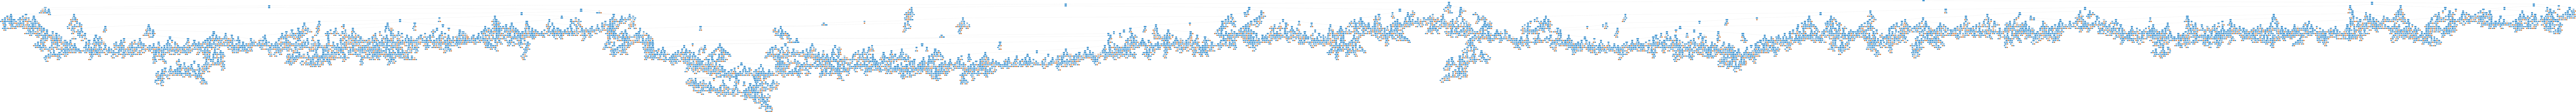

In [24]:
### MASSA RECURSIVITAT
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = ['CRSDepTime', 'ArrTime', 'CRSArrTime', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'DepDelay', 'Distance', 'TaxiIn',
       'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'DayOfWeek_1',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'DayOfWeek_7', 'deptime', 'depdate'], class_names=['0','1']) #NO ES UNA CLASSE, SON ESCALARS
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decisionTreeDelay.png')
Image(graph.create_png()) #### simple, quan poso ArrDelay per classificar. L'arbre es complica sense ArrDelay

## METODE 2: classificant logisticament

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(flightsdf.shape)

(133040, 24)
(133040,)
(133041, 24)
(133041,)
(266081, 24)


In [26]:
#generant instancia del model logistic   POSO retard en 2 bins, com abans. Però podrien ser 25, si cal
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=2000)

In [27]:
# entrenament del model amb els subsets
logisticRegr.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [28]:
# fem prediccions amb el test
logisticRegr.predict(X_test) #.reshape(1,-1))

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [29]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
### matriu de confusions
cm_logis=pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" ,cm_logis) 
#index F1
print("F1 index: ", metrics.f1_score(y_test, y_pred))

Accuracy: 0.939958358701453
Confusion matrix: 
       0       1
0   136    3254
1  4734  124917
F1 index:  0.9690173840866955


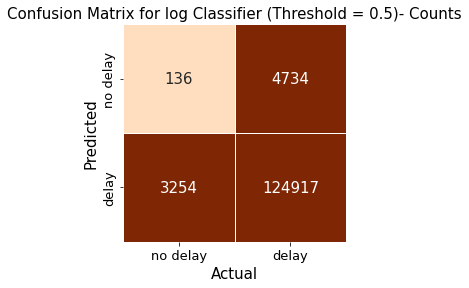

In [30]:
#Building Confusion matrices: Logistic - Threshold=0.5 - Counts

#Use a seaborn heatmap to plot confusion matrices
#The dataframe is transposed to make Actual values on x-axis and predicted on y-axis
#annot = True includes the numbers in each box
#vmin and vmax just adjusts the color gamut
fig, ax = plt.subplots(figsize = (4,4))
sns.heatmap(cm_logis.T, annot=True, annot_kws={"size": 15}, cmap="Oranges", vmin=0, vmax=800, fmt='.0f', linewidths=1, linecolor="white", cbar=False,
           xticklabels=["no delay","delay"], yticklabels=["no delay","delay"])
plt.ylabel("Predicted", fontsize=15)
plt.xlabel("Actual", fontsize=15)
ax.set_xticklabels(["no delay","delay"], fontsize=13)
ax.set_yticklabels(["no delay","delay"], fontsize=13)
plt.title("Confusion Matrix for log Classifier (Threshold = 0.5)- Counts", fontsize=15)

plt.show()

[[   136   3254]
 [  4734 124917]]
[[0.04011799 0.95988201]
 [0.03651341 0.96348659]]
          0         1
0  0.040118  0.959882
1  0.036513  0.963487


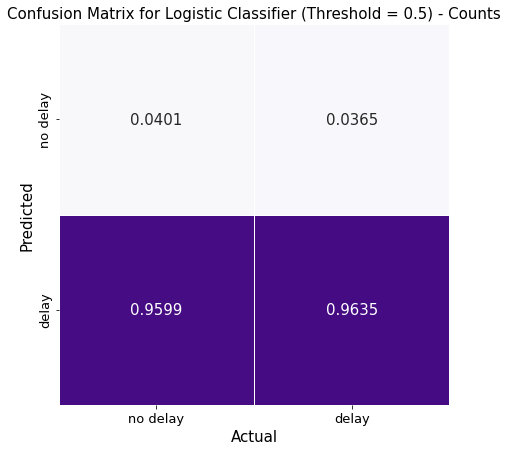

In [31]:
#plot CM normalized proportions ------- ES VEU QUE EL CLASIFICADOR ÉS UNA CACA DE LES DOLENTES PELS QUE NO PORTEN RETARD
nplogis=metrics.confusion_matrix(y_test, y_pred)
print (nplogis)
np_logis = nplogis.astype(float) / (nplogis.sum(axis=1)[:, np.newaxis])
print (np_logis)
cm_logis=pd.DataFrame(np_logis)
print (cm_logis)

fig, ax = plt.subplots(figsize = (7,7))
sns.heatmap(pd.DataFrame(cm_logis.T), annot=True, annot_kws={"size": 15}, cmap="Purples", vmin=0, vmax=1, fmt='.4f', linewidths=1, linecolor="white", cbar=False, #
    xticklabels=["no delay","delay"], yticklabels=["no delay","delay"])
plt.ylabel("Predicted", fontsize=15)
plt.xlabel("Actual", fontsize=15)
ax.set_xticklabels(["no delay","delay"], fontsize=13)
ax.set_yticklabels(["no delay","delay"], fontsize=13)
plt.title("Confusion Matrix for Logistic Classifier (Threshold = 0.5) - Counts", fontsize=15)
plt.show()

 # metode 3: KNN, intentant assimilar decalatges a algun conegut

In [32]:
y = np.array(ArrivalDelay.astype(np.int64)) # Target variable continua
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

#print("Class Counts")
#print(y_test.value_counts, end="\n\n")
#print("Class Proportions")
#print(y_test.value_counts()/len(y_test))

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [35]:
y_pred = classifier.predict(X_test) ### PREPARA QUE LA COSA VA LENTA

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[133041]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    133041

    accuracy                           1.00    133041
   macro avg       1.00      1.00      1.00    133041
weighted avg       1.00      1.00      1.00    133041



### ho clava, a costa que computacionalment és una mica pesat i força lent

In [37]:
error = []

# Calculating error for K values between 1 and 5
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

In [39]:
error

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Text(0, 0.5, 'Mean Error')

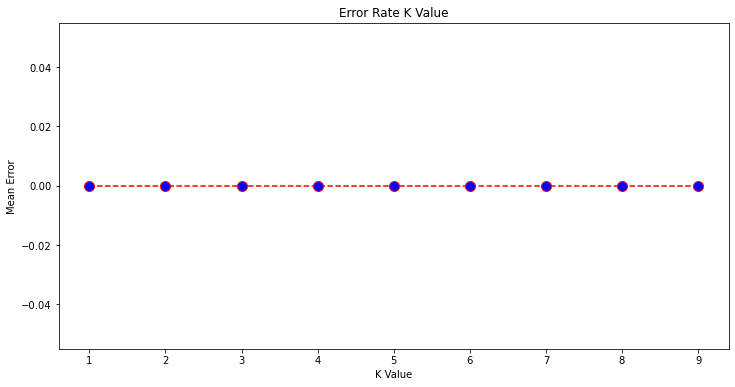

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# mètode 4: regressió linial --- WIP

In [55]:
# Step 2b: Transform input data
x_ = PolynomialFeatures(degree=1, include_bias=True).fit_transform(X)

# Step 3: Create a model and fit it
model = LinearRegression().fit(x_, y)

# Step 4: Get results
r_sq = model.score(x_, y)
intercept, coefficients = model.intercept_, model.coef_

# Step 5: Predict
y_pred = model.predict(x_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:557: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


In [56]:
print('coefficient of determination:', r_sq)

print('intercept:', intercept)

print('coefficients:', coefficients, sep='\n')

print('predicted response:', y_pred, sep='\n')

coefficient of determination: 0.041385563887191834
intercept: 1976934834221.0437
coefficients:
[ 4.54793761e+06  4.32380365e-01  3.01135599e-01 -6.03307675e-01
  2.78292115e+08  1.41002112e-01 -2.75762196e+08  7.15903556e-01
 -6.07182829e+07 -1.06762981e+08  1.72385161e+01 -8.01677437e+00
  8.82449603e+00 -3.61152118e+01 -1.20390484e+00 -1.94819746e+12
 -1.94819746e+12 -1.94819746e+12 -1.94819746e+12 -1.94819746e+12
 -1.94819746e+12 -1.94819746e+12 -2.87386354e+10 -2.87386353e+10
 -2.87386354e+10 -2.87386354e+10 -1.00370621e+11 -2.87386354e+10
 -2.87386353e+10 -2.87386352e+10 -2.87386354e+10 -2.87386354e+10
 -2.87386354e+10 -2.87386354e+10 -2.13550806e+11 -2.87386354e+10
 -2.87386353e+10 -2.87386354e+10 -2.87386354e+10 -2.87386354e+10
 -2.87386354e+10 -2.87386354e+10 -2.87386354e+10 -2.87386354e+10
 -2.87386354e+10 -2.87386354e+10 -2.87386354e+10 -2.87386354e+10
 -2.87386354e+10 -2.87386354e+10 -2.87386354e+10 -2.87386354e+10
 -2.87386354e+10 -2.87386354e+10 -1.14944889e+10 -2.87386354

In [80]:
quick_analysis(X)
#quick_analysis(y)

General Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2228885 entries, 0 to 7009718
Columns: 327 entries, CRSDepTime to depdate
dtypes: float64(327)
memory usage: 5.4 GB
Rows and Columns:
(266081, 325)
Column Names:
Index(['CRSDepTime', 'ArrTime', 'CRSArrTime', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay',
       ...
       'Origin_VLD', 'Origin_VPS', 'Origin_WRG', 'Origin_WYS', 'Origin_XNA',
       'Origin_YAK', 'Origin_YKM', 'Origin_YUM', 'deptime', 'depdate'],
      dtype='object', length=325)
Null Values:
CRSDepTime           0.0
ArrTime              0.0
CRSArrTime           0.0
ActualElapsedTime    0.0
CRSElapsedTime       0.0
                    ... 
Origin_YAK           0.0
Origin_YKM           0.0
Origin_YUM           0.0
deptime              0.0
depdate              0.0
Length: 325, dtype: float64


In [61]:
# idem però fent servir STATMODELS *****************************WWWWWWWWWWWWWWWWWWWWIIIIIIIPPPPPP
xm = np.array(sm.add_constant(X)) #### AFEGIM columna de termes independents 1,1,1,1,1,,1,1,1. No té DEFAULT

##agafat de la classe statsmodels.regression.linear_model.OLS ordinary least squares
model = sm.OLS(np.array(y), xm) 

results = model.fit()
print(results.summary())
print('coefficient of determination:', results.rsquared)
print('adjusted coefficient of determination:', results.rsquared_adj)
print('regression coefficients:', results.params)

print('predicted response: \n', results.fittedvalues, sep='\n') #els dos mètodes funcionen IGUAL
print('predicted response: \n', results.predict(xm), sep='\n')

#x_new = sm.add_constant(np.arange(10).reshape((-1, 2)))
#print(x_new)
#y_new = results.predict(x_new)
#print(y_new)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

sns.residplot(x=y, y=results.predict(xm), scatter_kws={"s": 80}); ### això seria un WARNING als residuals

- Exercici 5
Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

### S'han elaborat algunes transformacions a les variables d'entrada per adaptar-les a un model digerible i computable: dummy vars(), binning, binarize

- Exercici 6
No utilitzis la variable DepDelay a l’hora de fer prediccions

#### S'escull un model amb XGBOOST, eliminant DepDelay
#### Partint de cap i de nou amb el DF original i es reprocessa

In [26]:
flightsdf=pd.read_csv('DelayedFlights.csv', index_col=0) #a vegades cal posar index_col=0 si no fos detectat inicialment
#elimino els que NO han volat (airtime=0 o cancellats)
flightsdf.drop(flightsdf[flightsdf.AirTime==0].index, inplace=True) #, axis=0, inplace=True)
flightsdf.drop(flightsdf[flightsdf.Cancelled!=0].index, inplace=True)
flightsdf['DepDate'] = flightsdf['Month']*100+flightsdf['DayofMonth'] ###a enter, sense ,format='%Y%m%d' FORA flightsdf['Year']*10000
    ## després la posaré en BINS per mesos, quinzenal o setmanal, segons com vagi de memoria

flightsdf.drop(['Year', 'Month', 'DayofMonth', 'Cancelled','CancellationCode', 'TailNum', 'Diverted', 'UniqueCarrier', 'FlightNum'], axis=1, inplace=True)
flightsdf.dropna(inplace=True) #puc eliminar els NaN en general o podria eliminar només els que no tenen retards
#flightsdf.fillna(0) # o elimino els nan passant-los a 0

dummy_cols = ['DayOfWeek']
flightsdf = pd.get_dummies(flightsdf, columns = dummy_cols) 
dummy_cols = ['Origin']
flightsdf = pd.get_dummies(flightsdf, columns = dummy_cols) 

flightsdf.drop(['Dest'], axis=1, inplace=True)

# binning i bucking, buckets a 0 250 600 1200 1800 5000 per a ArrDelay (target classificador)
# a DepTime per hores, cal fer entre 24 i 48 capses, amb la resta de hores
# a DepDate per mesos, cal fer 12 capses

bindept = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300, 2400]
group_namesdt = ['00','01', '02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
#      dt_categories = pd.cut(flightsdf['DepTime'], bindept, labels=group_namesdt)
flightsdf['deptime'] = pd.to_numeric(pd.cut(flightsdf['DepTime'], bindept, labels=group_namesdt)) #,fo
#dt_categories
pd.value_counts(flightsdf['deptime'])

bindepd = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300]
group_namesdd = ['01','02','03','04','05','06','07','08','09','10','11','12']
                                    # es podria fer en blocs quinzenals, però tampoc es guanyaria res
flightsdf['depdate'] = pd.to_numeric(pd.cut(flightsdf['DepDate'], bindepd, labels=group_namesdd))
pd.value_counts(flightsdf['depdate'])

            ## ELIMINO columnes que ja he posat en bins, la que és TARGET i es podrien OneHotEncoder
flightsdf.drop(['DepDate','DepTime'], axis=1, inplace=True) #[,'ArrDelay']

#i finalment normalitzo les variables, TOTES, per facilitar la feina al fit()
#### CAL FER UN SCALING per tal de digerir l'algoritme de ML 

cols_to_norm = ['CRSDepTime', 'ArrTime', 'CRSArrTime',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime',
       'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay'] # off side: 'DepDate','DepTime' pq no son continues,-deixo les CRS per embogir el model.
                            #'DayOfWeek','Origin', 'Dest' son strings que passen a sparse matrix, 'depdate','deptime','DayOfWeek' son BINS
                             #'ArrDelay' es el Target, com Delayed
n_test = flightsdf[cols_to_norm]

x = n_test.values   #preparo per només passar array() NUMPY
x_scaled = preprocessing.MinMaxScaler().fit_transform(x)
left = pd.DataFrame(x_scaled, columns=cols_to_norm) # VARS normalizades, reconstrueixo df amb indexs
right= flightsdf.drop(cols_to_norm, axis=1).reset_index(drop=True) #['cols'] recalculades, what is left. fora- inplace=True
#flightsdf.drop(cols_to_norm, axis=1, inplace=True)


right.tail()
quick_analysis(left)
quick_analysis(right)
left.head(-10)
right.head(-10)

In [27]:
flightsdf = pd.merge(left, right, left_index=True, right_index=True)
#flightsdf=pd.concat([left, right], axis=1) #### EM GENERA MASSA NAN !!!!!!
flightsdf.columns

#elimino "DepDelay" de les variables del model
flightsdf.drop(['DepDelay'], axis=1, inplace=True)

#POST: tinc un dataframe normalitzat, amb bins i complet

quick_analysis(flightsdf)

General Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247483 entries, 0 to 1247482
Columns: 326 entries, CRSDepTime to depdate
dtypes: float64(15), int64(2), uint8(309)
memory usage: 529.4 MB
Rows and Columns:
(1247483, 326)
Column Names:
Index(['CRSDepTime', 'ArrTime', 'CRSArrTime', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay',
       ...
       'Origin_VLD', 'Origin_VPS', 'Origin_WRG', 'Origin_WYS', 'Origin_XNA',
       'Origin_YAK', 'Origin_YKM', 'Origin_YUM', 'deptime', 'depdate'],
      dtype='object', length=326)
Null Values:
CRSDepTime           0.0
ArrTime              0.0
CRSArrTime           0.0
ActualElapsedTime    0.0
CRSElapsedTime       0.0
                    ... 
Origin_YAK           0.0
Origin_YKM           0.0
Origin_YUM           0.0
deptime              0.0
depdate              0.0
Length: 326, dtype: float64


In [28]:
y = flightsdf['ArrDelay'] # Target variable X, y = data.iloc[:,:-1],data.iloc[:,-1]

flightsdf.drop(['ArrDelay'], axis=1, inplace=True) # elimino la columna target per passar el df complet amb sparse matrix

X = flightsdf

In [29]:
data_dmatrix = xgb.DMatrix(data=X,label=y, enable_categorical=True)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:273: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [31]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 15)

In [32]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=15, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
preds = xg_reg.predict(X_test)

In [36]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 40.534783


### farem cross-validations en petits lots per veure si funciona

##### Sabent que una sparse matrix no és la millor idea per a un XGB

In [ ]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10} #reg:squarederror reg:linear

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

cv_results.head()

In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))

In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [ ]:
xgb.plot_tree(xg_reg,num_trees=5) ###plot per cada regressor, no arbre general
plt.rcParams['figure.figsize'] = [500, 30]
plt.show()

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()